<a href="https://colab.research.google.com/github/Danpollak/Word2Note/blob/master/Model%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import tensorflow
import pickle as pk
from tqdm.notebook import tqdm
import statistics

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Embedding, Input, Concatenate
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [21]:
# vocabulary definition
class NoteLang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"unk": 0, "SOS": 1, "EOS": 2, "BREAK": 3}
        self.index2word = {0: "unk", 1: "SOS", 2: "EOS", 3: "BREAK"}
        self.note2index = {"unk": 0, "SOS": 1, "EOS": 2, "BREAK": 3}
        self.index2note = {0: "unk", 1: "SOS", 2: "EOS", 3: "BREAK"}
        self.word_level2index = {"unk": 0, "SOS": 1, "EOS": 2, "BREAK": 3}
        self.index2word_level = {0: "unk", 1: "SOS", 2: "EOS", 3: "BREAK"}
        self.n_words = 4
        self.n_notes = 4
        self.n_word_level = 4

    def addSentence(self, sentence):
        for subword in sentence:
            self.addWord(subword)

    def addWord(self, word):
        subword = word[0]
        note = word[1]
        word_level = word[2]

        # insert subwords
        if subword not in self.word2index:
            self.word2index[subword] = self.n_words
            self.index2word[self.n_words] = subword
            self.n_words += 1

        # insert notes
        if note not in self.note2index:
            self.note2index[note] = self.n_notes
            self.index2note[self.n_notes] = note
            self.n_notes += 1

        # insert word level
        if word_level not in self.word_level2index:
          self.word_level2index[word_level] = self.n_word_level
          self.index2word_level[self.n_word_level] = word_level
          self.n_word_level += 1

    def check_unk(self, subword, vocabulary):
        if subword in vocabulary:
          return vocabulary[subword]
        else:
          return vocabulary["unk"]

    def sentence2index(self,sentence):
        indexed_sentence = [self.check_unk(subword, self.word2index) for subword in sentence]
        return indexed_sentence

    def note_sentence2index(self,sentence):
        indexed_sentence = [self.check_unk(note, self.note2index) for note in sentence]
        return indexed_sentence

    def word_level_sentence2index(self,sentence):
        indexed_sentence = [self.check_unk(word_level, self.word_level2index) for word_level in sentence]
        return indexed_sentence

# reordering dataset for training and evaluation
def order_dataset(dataset, max_line_length, train=True):
    features = []
    labels = []
    words = []
    line_length = 0

    for song in tqdm(dataset):
      line = song[0]
      line_features  = []
      line_label = []
      line_word = []

      line_to_parse = [('SOS', 'SOS', 'SOS')]
      line_to_parse.extend(line)
      line_to_parse.append(('EOS', 'EOS', 'EOS'))

      for subword in line_to_parse:
        line_length+=1

        letter = subword[0]
        line_features.append(letter)

        note = subword[1]
        line_label.append(note)

        word = subword[2]
        line_word.append(word)

      # append whole line to dataset
      features.append(line_features)
      labels.append(line_label)
      words.append(line_word)

      if train:
          # get max line length
          max_line_length = max(max_line_length, line_length)
          line_length=0
          NoteVocab.addSentence(line_to_parse)

    # encode features and labels
    features = [NoteVocab.sentence2index(line) for line in tqdm(features)]
    labels = [NoteVocab.note_sentence2index(line) for line in tqdm(labels)]
    words = [NoteVocab.word_level_sentence2index(line) for line in tqdm(words)]

    # buffer features and labels
    features = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(features)]
    labels = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(labels)]
    words = [np.pad(line, (0,max_line_length - len(line)), constant_values=2) for line in tqdm(words)]

    # convert to numpy
    features = np.array(features)
    labels = np.array(labels)
    words = np.array(words)

    print("printing shapes for sainty check:")
    print(features.shape)
    print(labels.shape)
    print(words.shape)

    print("printing parsed data for sainty check:")
    print(features[0])
    print(labels[0])
    print(words[0])

    print("Max Line is:")
    print(max_line_length)

    return features, labels, words, max_line_length

# filtering out sentences by length
def filter_dataset(ds):
    train_set = ds['train']
    test_set = ds['test']
    
    print("Length Before Filtering is:")
    print("Train: " + str(len(train_set)))
    print("Test: " + str(len(test_set)))

    WINDOW_SIZE = 10
    median = statistics.median([len(song[0]) for song in train_set])
    print("Median Length is: " + str(median))

    train_set = [song for song in train_set if len(song[0]) < median and len(song[0]) > (median - WINDOW_SIZE )]
    test_set = [song for song in test_set if len(song[0]) < median and len(song[0]) > (median - WINDOW_SIZE)]

    print("Length After Filtering is:")
    print("Train: " + str(len(train_set)))
    print("Test: " + str(len(test_set)))

    return train_set, test_set

## Import Data

In [22]:
# importing data
from google.colab import drive
drive.mount('/content/drive')
data_path= '/content/drive/My Drive/Colab Notebooks/DALI/ds_characters_withword_split.pickle'
NoteVocab = NoteLang('word2note')
max_line_length = 0

with open(data_path, 'rb') as pickle_file:
    ds = pk.load(pickle_file)

train_set, test_set = filter_dataset(ds)

features, labels, words, max_line_length = order_dataset(train_set, max_line_length)
features_test, labels_test, words_test , _ = order_dataset(test_set, max_line_length, False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Length Before Filtering is:
Train: 170725
Test: 42681
Median Length is: 23
Length After Filtering is:
Train: 56358
Test: 14192



printing shapes for sainty check:
(56358, 24)
(56358, 24)
(56358, 24)
printing parsed data for sainty check:
[ 1  4  5  6  7  8  9 10 11  6  7 12  9  5  7 13  9 14 14 12  7  2  2  2]
[1 4 5 5 3 6 7 7 7 7 3 6 7 7 3 8 9 9 8 9 3 2 2 2]
[1 4 4 4 3 5 5 5 5 5 3 6 6 6 3 7 7 7 7 7 3 2 2 2]
Max Line is:
24



printing shapes for sainty check:
(14192, 24)
(14192, 24)
(14192, 24)
printing parsed data for sainty check:
[ 1 13 21 22 10  7  6 21 22  8 14 22 19 16  7 15 25  7 18  9 10 22  7  2]
[ 1 22 23 23 23  3 60 61 61 61 61 61 61 61  3 33 80  3 85 86 86 86  3  2]
[  1 117 117 117 117   3   0   0   0   0   0   0   0   0   3  42  42   3
 566 566 566 566   3   2]
Max Line is:
24


## Models

## Sentence2Note LSTM

In [23]:
# Hyperparameters
vocab_size = NoteVocab.n_words
number_of_notes = NoteVocab.n_notes
word_level_vocab = NoteVocab.n_word_level
word_embedding_size = 100
LSTM_embedding_size = 100
char_embedding_size = 10

Model: "Note_Seq2Seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Word_Level_Input (InputLayer)   [(None, 24)]         0                                            
__________________________________________________________________________________________________
Note_Decoder_Inputs_Word (Input [(None, 24)]         0                                            
__________________________________________________________________________________________________
Note_Encoder_Inputs_Word (Input [(None, 24)]         0                                            
__________________________________________________________________________________________________
Word_Level_Embbeding (Embedding (None, 24, 100)      964100      Word_Level_Input[0][0]           
_______________________________________________________________________________________

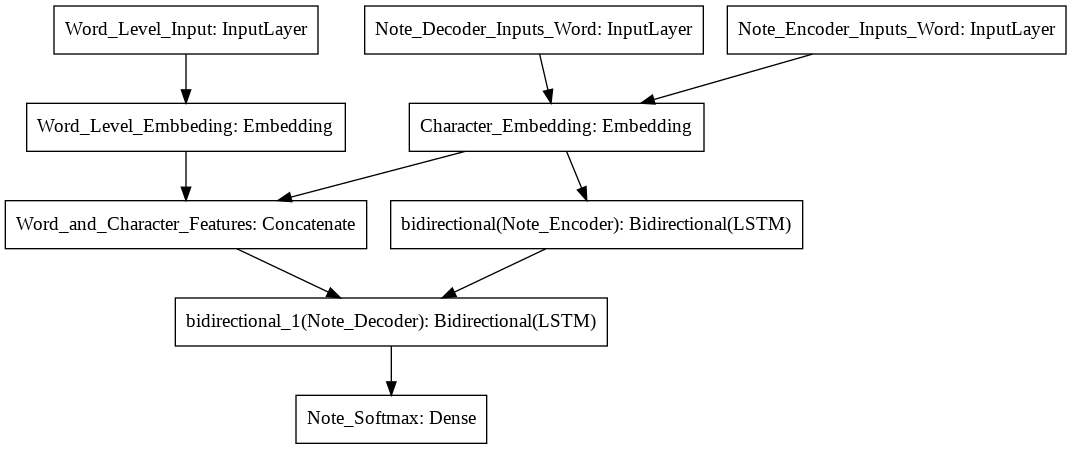

In [24]:
# define inputs
word_level_input = Input(shape=(max_line_length), dtype='int32', name="Word_Level_Input")
note_encoder_inputs_word = Input(shape=(max_line_length), dtype='float32', name="Note_Encoder_Inputs_Word")
note_decoder_inputs_word = Input(shape=(max_line_length), dtype='float32', name="Note_Decoder_Inputs_Word")

# char level embbeding
char_embedding_layer = Embedding(input_dim=vocab_size, output_dim=char_embedding_size, input_length=max_line_length, name="Character_Embedding")
char_encoder_input = char_embedding_layer(note_encoder_inputs_word)
char_decoder_input = char_embedding_layer(note_decoder_inputs_word)

# word level embbeding
word_level_embedding_layer = Embedding(input_dim=word_level_vocab, output_dim=word_embedding_size, input_length=max_line_length, name="Word_Level_Embbeding")
word_level_embedding = word_level_embedding_layer(word_level_input)

# concatenating word and char level embbedings
decoder_input = Concatenate(axis=2, name="Word_and_Character_Features")([word_level_embedding, char_decoder_input])

# defining LSTM Encoder
note_encoder_LSTM = LSTM(LSTM_embedding_size, return_state=True, name="Note_Encoder")
note_encoder_LSTM_bidrectional = Bidirectional(note_encoder_LSTM)

# getting LSTM Encoder output
_ , *encoder_states = note_encoder_LSTM_bidrectional(char_encoder_input)

# defining LSTM Decoder
note_decoder_LSTM = LSTM(LSTM_embedding_size, return_state=True, return_sequences=True, name="Note_Decoder")
note_decoder_LSTM_bidrectional = Bidirectional(note_decoder_LSTM)

# getting LSTM Decoder output
note_decoder_outputs, _, _, _ ,_ = note_decoder_LSTM_bidrectional(decoder_input, initial_state=encoder_states)

# note softmax
note_decoder_dense = Dense(number_of_notes, activation='softmax', name="Note_Softmax")
note_decoder_outputs = note_decoder_dense(note_decoder_outputs)

# model definition for training
model = Model([note_encoder_inputs_word  ,note_decoder_inputs_word, word_level_input], note_decoder_outputs,name="Note_Seq2Seq")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 

# print and plot model metadata    
model.summary()
keras.utils.plot_model(model, expand_nested=True)

## Training

In [25]:
epochs=50

In [26]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [27]:
%%time
# input to encoder is the feature sentence
# input to decoder is the hidden and context vector, and feature sentence
train_metadata = model.fit([features, features, words], labels,
          batch_size=32,
          epochs=epochs,
          validation_split=0.3,
          callbacks=[model_checkpoint_callback],
          )
history = train_metadata.history

Epoch 1/50
1233/1233 [==============================] - 54s 44ms/step - loss: 2.2432 - sparse_categorical_accuracy: 0.4268 - val_loss: 2.1567 - val_sparse_categorical_accuracy: 0.4270
Epoch 2/50
1233/1233 [==============================] - 52s 42ms/step - loss: 1.9670 - sparse_categorical_accuracy: 0.4820 - val_loss: 2.2433 - val_sparse_categorical_accuracy: 0.4269
Epoch 3/50
1233/1233 [==============================] - 53s 43ms/step - loss: 1.7676 - sparse_categorical_accuracy: 0.5300 - val_loss: 2.3392 - val_sparse_categorical_accuracy: 0.4240
Epoch 4/50
1233/1233 [==============================] - 53s 43ms/step - loss: 1.6331 - sparse_categorical_accuracy: 0.5598 - val_loss: 2.4399 - val_sparse_categorical_accuracy: 0.4234
Epoch 5/50
1233/1233 [==============================] - 52s 42ms/step - loss: 1.5384 - sparse_categorical_accuracy: 0.5813 - val_loss: 2.5197 - val_sparse_categorical_accuracy: 0.4239
Epoch 6/50
1233/1233 [==============================] - 53s 43ms/step - loss: 1.

## Inference

In [ ]:
model.load_weights(checkpoint_filepath)

In [28]:
def decode_sequence(features, words):
    output_tokens = model.predict([features, features, words])
    # Sample a token
    decoded_sentence = np.squeeze(np.argmax(output_tokens, axis=2))
    sentence = list(map(lambda x : NoteVocab.index2note[x], decoded_sentence))
    return sentence

In [113]:
instance_id = 453
concat_pred_test = np.concatenate((features_test, words_test), axis=1)
pred_test = list(tqdm(map(lambda x :decode_sequence(np.expand_dims(x[:24], axis=0),np.expand_dims(x[24:],axis=0)),concat_pred_test)))
pred_test_ds = pred_test
print(pred_test[0])
#print(decode_sequence(np.expand_dims(features_test[instance_id], axis=0), np.expand_dims(words_test[instance_id], axis=0)))
#print(list(map(lambda x : NoteVocab.index2note[x], labels_test[instance_id])))


['SOS', 'E4_S', 'E4', 'E4', 'E4', 'BREAK', 'F4_S', 'F4', 'F4', 'E5', 'E5_S', 'A5', 'A5', 'B5', 'BREAK', 'F5_S', 'F#5', 'BREAK', 'F5_S', 'F5', 'A5', 'E5', 'BREAK', 'EOS']


In [46]:
eval_hist = model.evaluate(
    x=[features_test, features_test, words_test],
    y=labels_test,
)

444/444 [==============================] - 6s 13ms/step - loss: 4.8717 - sparse_categorical_accuracy: 0.4314


## Evaluation

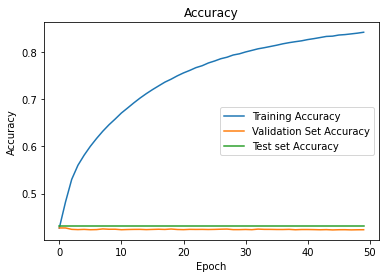

In [47]:
plt.plot(history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

x = np.linspace(0,epochs - 1)
y = np.full(x.shape, eval_hist[1])
plt.plot(x, y, label='Test set Accuracy')

plt.title("Accuracy")
plt.legend()
plt.show()

In [228]:
# Note Line validity - Is the line valid "grammaticaly".

def notes_validity(notes):
  sum_of_errors = 0
  for note_line in notes:
    error = 0
    if line[0] != 'SOS':
        print('Sentence did not start with SOS')
        error+=1
    for i in range(1,len(note_line)):
      prev_note = note_line[i-1]
      current_note = note_line[i]
      # Case 1: Regular note
      # Legal Prev Note: SOS, BREAK, similar note with or without _S
      if NoteVocab.note2index[current_note] > 4 and not current_note.endswith('_S'):
        # If SOS or BREAK, continue
        if prev_note == 'SOS' or prev_note == 'BREAK':
          continue
        # If the prev note is the same or the same with _S, continue
        if prev_note == current_note or prev_note == current_note + '_S':
          continue
        #print("Current Note: " + current_note + ", Prev Note: " + prev_note)
        error+=1
      # Case 2: Note with _S
      # Legal Prev Note: Anything but EOF
      if current_note.endswith('_S'):
        if prev_note == 'EOS':
          #print("Current Note: " + current_note + ", Prev Note: " + prev_note)
          error+=1
      # Case 3: BREAK
      # Legal Prev Note: Any note
      if current_note == 'BREAK':
        if NoteVocab.note2index[prev_note] > 4:
          continue
        #print("Current Note: " + current_note + ", Prev Note: " + prev_note)
        error+=1
      # Case 4: SOS
      # Legal: Never
      if current_note == 'SOS':
        #print("Current Note: " + current_note + ", Prev Note: " + prev_note)
        error+=1
      # Case 5: EOS
      # Legal: Any character
        
    sum_of_errors+=error

  return sum_of_errors/notes.shape[0]

In [49]:
note2midi = {
    'C3':48,
    'C#3':49,
    'D3':50,
    'D#3':51,
    'E3':52,
    'F3':53,
    'F#3':54,
    'G3':55,
    'G#3':56,
    'A3':57,
    'A#3':58,
    'B3':59,
    'C4':60,
    'C#4':61,
    'D4':62,
    'D#4':63,
    'E4':64,
    'F4':65,
    'F#4':66,
    'G4':67,
    'G#4':68,
    'A4':69,
    'A#4':70,
    'B4':71,
    'C5':72,
    'C#5':73,
    'D5':74,
    'D#5':75,
    'E5':76,
    'F5':77,
    'F#5':78,
    'G5':79,
    'G#5':80,
    'A5':81,
    'A#5':82,
    'B5':83,
    'C6':84
}

In [131]:
# Note Distance - Check if the distance between the lowest and highest note is different.

def note_distance_metric(gt, pred, threshold):
  gt_distances = np.array(list(map(lambda x: get_note_line_distance(x,isIndex=True), gt)))
  pred_distances = np.array(list(map(get_note_line_distance, pred)))
  distance_delta = pred_distances - gt_distances
  avg = np.mean(distance_delta)
  distance_delta = distance_delta[distance_delta < threshold]
  return avg, len(distance_delta)/len(pred_distances)


def get_note_line_distance(line, isIndex=False):
  min_note = 100
  max_note = 0
  for note in line:
    if isIndex:
      note = NoteVocab.index2note[note]
    if note.endswith('_S'):
      note = note[:-2]
    if note in note2midi:
      note_value = note2midi[note]
      min_note = min(min_note, note_value)
      max_note = max(max_note,note_value)
  return max_note - min_note

  

In [145]:
# Note Fluidity - Check the deltas between all notes and compute variance between

def note_fluidity_metric(gt, pred, threshold):
  gt_distances = np.array(list(map(lambda x: get_note_line_fluditiy(x,isIndex=True), gt)))
  pred_distances = np.array(list(map(get_note_line_fluditiy, pred)))
  distance_delta = pred_distances - gt_distances
  avg = np.mean(distance_delta)
  distance_delta = distance_delta[distance_delta < threshold]
  return avg, len(distance_delta)/len(pred_distances)


def get_note_line_fluditiy(line,isIndex=False):
  min_note = 100
  max_note = 0
  notes_progression = []
  prev_note = ''
  for note in line:
    if isIndex:
      note = NoteVocab.index2note[note]
    if note in note2midi:
      if note is not prev_note:
        prev_note = note
        notes_progression.append(note2midi[note])
  note_deltas = 0
  for i in range(len(notes_progression)-1):
    note_deltas+= abs(notes_progression[i+1] - notes_progression[i])
  return note_deltas

In [226]:
# Smoothing functions

def smooth_first_note(line):
  last_note = 'BREAK'
  smooth_line = []
  for note in line:
    if note.endswith('_S'):
      last_note = note[:-2]
    if NoteVocab.note2index[note] > 4 and not note.endswith('_S'):
      smooth_line.append(last_note)
    else:
      smooth_line.append(note)
  return smooth_line

def smooth_majority_note(line):
  note_dict = dict()
  smooth_line = []
  for note in line:
    if note.endswith('_S'):
      if len(note_dict) > 0:
        majority_note = decide_majority_note(note_dict)
        smooth_line = np.append(smooth_line,majority_note)
        note_dict = dict()
      note_dict[note[:-2]] = 1
    elif NoteVocab.note2index[note] > 4 and not note.endswith('_S'):
      if note in note_dict:
        note_dict[note]+=1
      else:
        note_dict[note] = 1
    else:
      if len(note_dict) > 0:
        majority_note = decide_majority_note(note_dict)
        smooth_line = np.append(smooth_line,majority_note)
        note_dict = dict()
      smooth_line = np.append(smooth_line,note)
  return smooth_line

def decide_majority_note(note_dict):
  majority_note = max(note_dict, key=note_dict.get)
  majority_note_array = [majority_note + '_S']
  majority_note_array = np.append(majority_note_array,np.full(sum(note_dict.values())-1,majority_note))
  return majority_note_array

In [233]:
pred_test_smooth_first_note = np.array(list(map(smooth_first_note,pred_test)))
pred_test_smooth_majority_note = np.array(list(map(smooth_majority_note,pred_test)))

# Line Validity errors average
avg_validity_errors_no_smooth = notes_validity(pred_test)
avg_validity_errors_first_note_smooth = notes_validity(pred_test_smooth_first_note)
avg_validity_errors_majority_note_smooth = notes_validity(pred_test_smooth_majority_note)

# Note Distance delta rate. Threshold = 12 (Octave)
avg_note_distance_delta_no_smooth, dist_threshold_no_smooth = note_distance_metric(labels_test, pred_test, 12)
avg_note_distance_delta_first_note_smooth, dist_threshold_first_smooth = note_distance_metric(labels_test, pred_test_smooth_first_note, 12)
avg_note_distance_delta_majority_note_smooth, dist_threshold_majority_smooth = note_distance_metric(labels_test, pred_test_smooth_majority_note, 12)


# Note Fluditiy delta rate. Threshold = 12 (Octave)
avg_note_fluidity_delta_no_smooth, _ = note_fluidity_metric(labels_test, pred_test, 12)
avg_note_fluidity_delta_first_note_smooth, _ = note_fluidity_metric(labels_test, pred_test_smooth_first_note, 12)
avg_note_fluidity_delta_majority_note_smooth, _ = note_fluidity_metric(labels_test, pred_test_smooth_majority_note, 12)


# No Smooth
print('Average validity errors per line for no smooth: ' + str(avg_validity_errors_no_smooth))
print("Average delta of note distances with no smooth: " + str(avg_note_distance_delta_no_smooth))
print("Precentage of octave deviations with no smooth: " + str(1 - dist_threshold_no_smooth))
print("Average delta of note fludity with no smooth: " + str(avg_note_fluidity_delta_no_smooth))
print()

# First Note Smooth
print('Average validity errors per line for first note smooth: ' + str(avg_validity_errors_first_note_smooth))
print("Average delta of note distances with first note smooth: " + str(avg_note_distance_delta_first_note_smooth))
print("Precentage of octave deviations with first note smooth: " + str(1 - dist_threshold_first_smooth))
print("Average delta of note fludity with first note smooth: " + str(avg_note_fluidity_delta_first_note_smooth))
print()

# Majority Note Smooth
print('Average validity errors per line for majority note smooth: ' + str(avg_validity_errors_majority_note_smooth))
print("Average delta of note distances with majority note smooth: " + str(avg_note_distance_delta_majority_note_smooth))
print("Precentage of octave deviations with majority note smooth: " + str(1 - dist_threshold_majority_smooth))
print("Average delta of note fludity with majority note smooth: " + str(avg_note_fluidity_delta_majority_note_smooth))




Average validity errors per line for no smooth: 2.9145997745208567
Average delta of note distances with no smooth: 8.246054114994363
Precentage of octave deviations with no smooth: 0.3283540022547914
Average delta of note fludity with no smooth: 15.761485343855693

Average validity errors per line for first note smooth: 0.02712795941375423
Average delta of note distances with first note smooth: 5.42087091319053
Precentage of octave deviations with first note smooth: 0.1933483652762119
Average delta of note fludity with first note smooth: 7.423196166854566

Average validity errors per line for majority note smooth: 0.02705749718151071
Average delta of note distances with majority note smooth: 5.348224351747463
Precentage of octave deviations with majority note smooth: 0.18848647125140927
Average delta of note fludity with majority note smooth: 7.1752395715896276
